In [1]:
from sklearn.cluster import KMeans
import numpy as np 
import pandas as pd 

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Predicting machine failure with data from an air compressor on a MetroPT3 locomotive 

In [2]:
# Reading in MetroPT3 Air Compressor data

n = 50  # every 100th line = 1% of the lines
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', header=0, skiprows=lambda i: i % n != 0)

#metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', nrows=800000)
metro_df_large.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,490,2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,990,2020-02-01 00:16:21,-0.012,8.408,8.394,-0.022,8.408,51.225,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1490,2020-02-01 00:24:37,10.314,9.944,-0.014,-0.024,9.940,49.825,6.1825,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,1990,2020-02-01 00:32:52,-0.012,9.434,9.418,-0.022,9.436,53.550,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,2490,2020-02-01 00:41:08,-0.014,8.926,8.910,-0.022,8.926,52.700,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


Attribute Information:
The dataset consists of 15169480 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
* #1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	
* #1 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00
* #3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00
* #4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [3]:
metro_df_large.shape

(30338, 17)

# Exploratory Data Analysis

In [4]:
# Summary statistics of the numeric features
metro_df_large.describe()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,3.033800e+04,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000,30338.000000
mean,7.584740e+06,1.373629,8.986417,7.568007,0.056442,8.987033,62.650438,2.048264,0.837399,0.160624,0.920628,0.832982,0.003362,0.991694,0.904311,0.937306
std,4.378985e+06,3.258334,0.638292,3.332764,0.383222,0.637511,6.524584,2.304029,0.369008,0.367190,0.270324,0.372998,0.057887,0.090762,0.294169,0.242415
min,4.900000e+02,-0.030000,0.894000,-0.032000,-0.032000,0.876000,19.800000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.792615e+06,-0.014000,8.494000,8.254000,-0.022000,8.496000,57.725000,0.040000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,7.584740e+06,-0.012000,8.962000,8.788000,-0.020000,8.962000,62.762500,0.045000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.137686e+07,-0.010000,9.494000,9.378000,-0.018000,9.494000,67.275000,3.807500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.516899e+07,10.608000,10.246000,10.238000,6.368000,10.242000,88.775000,8.847500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30338 entries, 0 to 30337
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       30338 non-null  int64  
 1   timestamp        30338 non-null  object 
 2   TP2              30338 non-null  float64
 3   TP3              30338 non-null  float64
 4   H1               30338 non-null  float64
 5   DV_pressure      30338 non-null  float64
 6   Reservoirs       30338 non-null  float64
 7   Oil_temperature  30338 non-null  float64
 8   Motor_current    30338 non-null  float64
 9   COMP             30338 non-null  float64
 10  DV_eletric       30338 non-null  float64
 11  Towers           30338 non-null  float64
 12  MPG              30338 non-null  float64
 13  LPS              30338 non-null  float64
 14  Pressure_switch  30338 non-null  float64
 15  Oil_level        30338 non-null  float64
 16  Caudal_impulses  30338 non-null  float64
dtypes: float64(1

In [6]:
metro_df_large['timestamp'] = pd.to_datetime(metro_df_large['timestamp'])

# Creating a target feature

The valuable information of the actual machinery failures needs to be transformed into a feature in the dataframe. Here I take steps to create failure_start, failure_end, and failure_duration features. I will use these to test the performance of the classification model.

In [7]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dt_fail_ends = pd.to_datetime(['04/18/2020 23:59', '05/30/2020 6:00', '06/07/2020 14:30', '07/15/2020 19:00'])

failure_df = pd.DataFrame(list(zip(dt_fail_starts, dt_fail_ends)), columns=['failure_start','failure_end'], dtype='datetime64[ns]')

failure_df.dtypes

failure_start    datetime64[ns]
failure_end      datetime64[ns]
dtype: object

In [8]:
# Creating a fail_duration feature by subtracting datetime objects, returning a timedelta

failure_df['fail_duration'] = failure_df['failure_end'] - failure_df['failure_start'] 
failure_df['fail_date'] = failure_df['failure_start'].dt.date
print(failure_df.head())
print(failure_df.dtypes)

        failure_start         failure_end   fail_duration   fail_date
0 2020-04-18 00:00:00 2020-04-18 23:59:00 0 days 23:59:00  2020-04-18
1 2020-05-29 23:30:00 2020-05-30 06:00:00 0 days 06:30:00  2020-05-29
2 2020-06-05 10:00:00 2020-06-07 14:30:00 2 days 04:30:00  2020-06-05
3 2020-07-15 14:30:00 2020-07-15 19:00:00 0 days 04:30:00  2020-07-15
failure_start     datetime64[ns]
failure_end       datetime64[ns]
fail_duration    timedelta64[ns]
fail_date                 object
dtype: object


In [9]:
# Creating date ranges to identify records from the 7 days leading up to failure
fail_ranges = [pd.date_range(start=(fail_start - pd.Timedelta(days=7)), end=fail_start) for fail_start in failure_df.fail_date]
fail_ranges

[DatetimeIndex(['2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
                '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
                '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
                '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05'],
               dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11',
                '2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15'],
               dtype='datetime64[ns]', freq='D')]

In [10]:
failure_dates = ['2020-04-18','2020-05-29','2020-06-05','2020-07-15']
failure_dts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dates_regex = '|'.join(failure_dates)
failure_dts

DatetimeIndex(['2020-04-18 00:00:00', '2020-05-29 23:30:00',
               '2020-06-05 10:00:00', '2020-07-15 14:30:00'],
              dtype='datetime64[ns]', freq=None)

In [11]:
metro_df_large['fail_state'] = metro_df_large.timestamp.dt.round('H').isin(fail_ranges[0])

In [12]:
metro_df_large['fail_state'].value_counts() 

False    30298
True        40
Name: fail_state, dtype: int64

In [13]:
metro_df_large.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_state
0,490,2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False
1,990,2020-02-01 00:16:21,-0.012,8.408,8.394,-0.022,8.408,51.225,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False
2,1490,2020-02-01 00:24:37,10.314,9.944,-0.014,-0.024,9.940,49.825,6.1825,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,False
3,1990,2020-02-01 00:32:52,-0.012,9.434,9.418,-0.022,9.436,53.550,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False
4,2490,2020-02-01 00:41:08,-0.014,8.926,8.910,-0.022,8.926,52.700,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False


In [14]:
failed_df = metro_df_large.loc[metro_df_large['fail_state'] == 1]
#failed_df['date'] = failed_df.timestamp.dt.date
failed_df

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_state
10308,5154490,2020-04-10 23:31:55,-0.016,8.272,8.264,-0.024,8.274,54.650,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10309,5154990,2020-04-10 23:40:11,-0.014,9.682,9.670,-0.024,9.680,63.075,3.7650,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10310,5155490,2020-04-10 23:48:27,-0.016,8.994,8.982,-0.024,8.994,57.375,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10311,5155990,2020-04-10 23:56:42,-0.014,8.318,8.308,-0.024,8.320,54.325,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10312,5156490,2020-04-11 00:04:58,-0.012,9.700,9.690,-0.022,9.698,64.450,3.7775,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10313,5156990,2020-04-11 00:13:13,-0.014,8.898,8.886,-0.024,8.898,56.950,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10314,5157490,2020-04-11 00:21:29,-0.016,8.286,8.274,-0.024,8.288,54.100,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10315,5157990,2020-04-11 00:29:44,-0.014,9.798,9.786,-0.024,9.798,65.175,3.8425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10453,5226990,2020-04-11 23:35:24,-0.014,8.596,8.586,-0.024,8.598,56.425,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,True
10454,5227490,2020-04-11 23:43:40,8.986,8.564,-0.018,0.120,8.562,54.000,5.9750,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,True


In [15]:
# Creating a dataframe to compare aggregate values between period leading up to a failure and period of normal operation
# ADJUST to use only pre failure period data for 'normal operation'
data = {'near_failure_oil_temp': failed_df['Oil_temperature'], 'normal_oil_temp': metro_df_large['Oil_temperature']}
oil_temp_diff = pd.DataFrame(data=data)
oil_temp_diff.describe()

,near_failure_oil_temp,normal_oil_temp
count,40.000000,30338.000000
mean,58.936875,62.650438
std,6.111829,6.524584
min,49.450000,19.800000
25%,54.425000,57.725000
50%,57.337500,62.762500
75%,63.262500,67.275000
max,74.075000,88.775000


In [16]:
# Every value of the Caudal_impulses and Oil_level columns is 1, 
# REQUIRES examination of full dataset before dropping these columns

print(metro_df_large.Caudal_impulses.value_counts())
print(metro_df_large.Oil_level.value_counts())

1.0    28436
0.0     1902
Name: Caudal_impulses, dtype: int64
1.0    27435
0.0     2903
Name: Oil_level, dtype: int64


# Initial Model Training + Evaluation

In [17]:
#logreg_1 = LogisticRegression()

# Feature Extraction

The BAR pressure value in the reservoirs ('Reservoirs') should be close to that measured at the pneumatic panel (TP3).
Next I create a dif_panel_reservoir feature by subtracting the value of 'Reservoirs' from the value of 'TP3' for each record.

In [18]:
# Creating a feature dif_panel_reservoir by subtracting Reservoirs value from TP3 value

metro_df_large['dif_panel_reservoir'] = abs(metro_df_large['TP3'] - metro_df_large['Reservoirs'])

metro_df_large['dif_panel_reservoir'].describe()

count    30338.000000
mean         0.001852
std          0.001696
min          0.000000
25%          0.000000
50%          0.002000
75%          0.002000
max          0.018000
Name: dif_panel_reservoir, dtype: float64

Creating a feature for the rolling average of the oil temperature.

In [19]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head(20)

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_state,dif_panel_reservoir,oil_rolling
0,490,2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.004,NaN
1,990,2020-02-01 00:16:21,-0.012,8.408,8.394,-0.022,8.408,51.225,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,NaN
2,1490,2020-02-01 00:24:37,10.314,9.944,-0.014,-0.024,9.940,49.825,6.1825,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,False,0.004,NaN
3,1990,2020-02-01 00:32:52,-0.012,9.434,9.418,-0.022,9.436,53.550,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.002,NaN
4,2490,2020-02-01 00:41:08,-0.014,8.926,8.910,-0.022,8.926,52.700,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,NaN
5,2990,2020-02-01 00:49:23,-0.014,8.462,8.446,-0.024,8.462,51.150,0.0375,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,51.850000
6,3490,2020-02-01 00:57:39,8.894,8.552,-0.024,-0.024,8.548,49.625,5.9800,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,False,0.004,51.345833
7,3990,2020-02-01 01:05:54,-0.012,9.466,9.450,-0.022,9.466,52.650,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,51.583333
8,4490,2020-02-01 01:14:10,-0.014,8.954,8.938,-0.024,8.956,52.525,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.002,52.033333
9,4990,2020-02-01 01:22:26,-0.014,8.484,8.472,-0.022,8.486,51.025,0.0375,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.002,51.612500


In [20]:
"""metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()"""

'metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)\nmetro_df_clustering.info()'

In [21]:
"""# Set up KMeans
kmeans = KMeans(n_clusters=4, n_init=10)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"""

"# Set up KMeans\nkmeans = KMeans(n_clusters=4, n_init=10)\n\n# Fit the model to the data\nkmeans.fit(metro_df_clustering)\n\n# Predict the clusters\nmetro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"

In [22]:
metro_df_large.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_state,dif_panel_reservoir,oil_rolling
0,490,2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.004,NaN
1,990,2020-02-01 00:16:21,-0.012,8.408,8.394,-0.022,8.408,51.225,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,NaN
2,1490,2020-02-01 00:24:37,10.314,9.944,-0.014,-0.024,9.940,49.825,6.1825,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,False,0.004,NaN
3,1990,2020-02-01 00:32:52,-0.012,9.434,9.418,-0.022,9.436,53.550,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.002,NaN
4,2490,2020-02-01 00:41:08,-0.014,8.926,8.910,-0.022,8.926,52.700,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,0.000,NaN


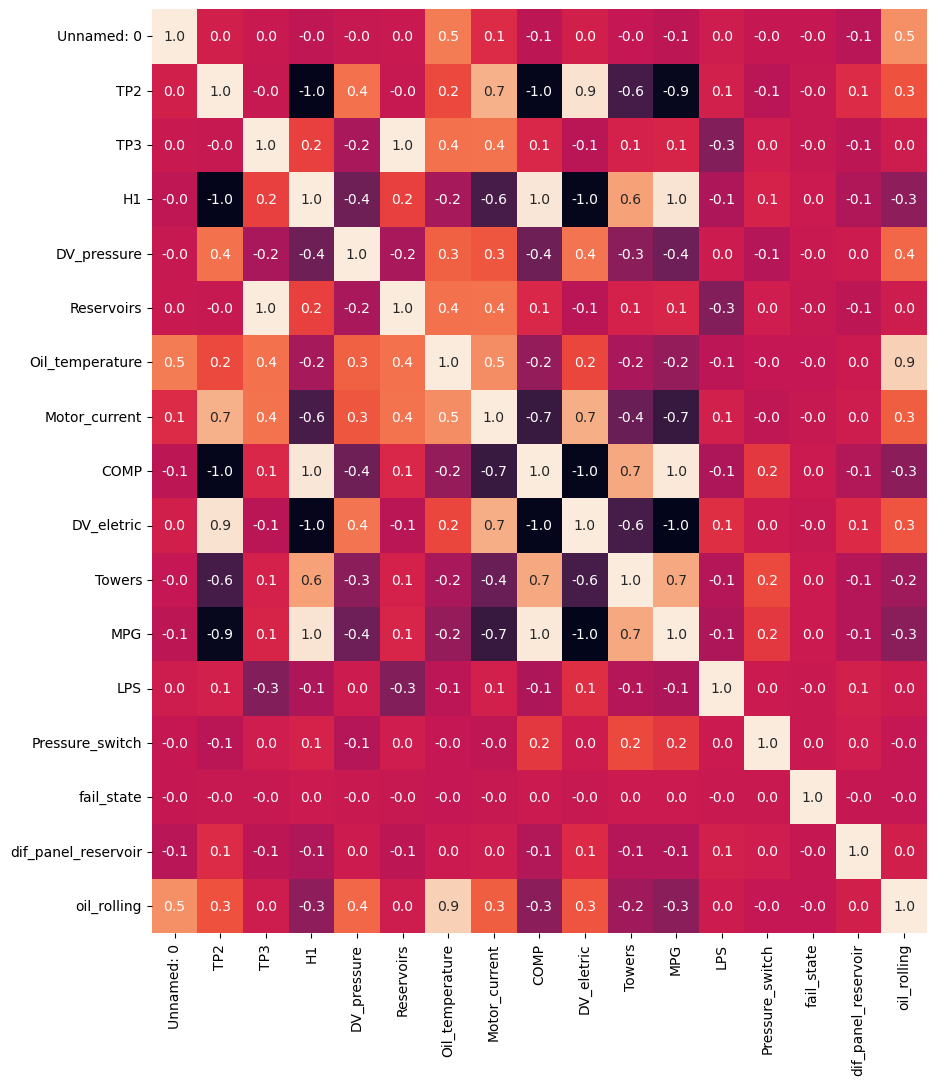

In [23]:
fig = plt.figure(figsize=(10,12))
hm = metro_df_large.drop(columns=['Oil_level','Caudal_impulses'], axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()

In [24]:
"""cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()
cluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()


cluster_0_df.head()"""


'cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()\ncluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()\ncluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()\ncluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()\n\n\ncluster_0_df.head()'

In [25]:
#cluster_0_df.describe()

In [26]:
#cluster_1_df.describe()

In [27]:
#cluster_2_df.describe()

In [28]:
# Using the pandas dataframe correlation matrix to create a heatmap of pairwise correlations
"""fig = plt.figure(figsize=(10,12))
hm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()"""

"fig = plt.figure(figsize=(10,12))\nhm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)\nsns.heatmap(hm, annot=True, fmt='.1f', cbar=False)\nplt.show()"

Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 